In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

2024-01-20 10:04:45.721804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 10:04:45.802539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 10:04:45.804214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 10:04:47.423265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Dia', 'Mês', 'Ano']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.index = df.index.tz_localize("America/Sao_Paulo")
#df['week'] = df.index.isocalendar().week
df['week'] = df.index.strftime('%Y-w%V')

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario', 'week']]
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca

#todo: preencher os valores faltantes

/tmp/ipykernel_1734745/2267417620.py:1: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',',


,Preco_unitario,week
dt,,
2016-04-22 00:00:00-03:00,0.61650,2016-w16
2016-04-29 00:00:00-03:00,0.42611,2016-w17
2016-05-06 00:00:00-03:00,0.43778,2016-w18
2016-05-13 00:00:00-03:00,0.43056,2016-w19
2016-05-20 00:00:00-03:00,0.44444,2016-w20
...,...,...
2023-08-25 00:00:00-03:00,0.40833,2023-w34
2023-08-31 00:00:00-03:00,0.37500,2023-w35
2023-09-08 00:00:00-03:00,0.35417,2023-w36


In [35]:
weather_df_2023 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2023_A_30-09-2023.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

weather_df_2022 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

weather_df_2021 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2021_A_31-12-2021.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

weather_df_2020 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2020_A_31-12-2020.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

weather_df_2019 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2019_A_31-12-2019.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

#todo: ver como importar os dados de 2016, 2017 e 2018 (estão em outro formato)

weather_df = pd.concat([weather_df_2019, weather_df_2020, weather_df_2021, weather_df_2022, weather_df_2023])
#weather_df.index = weather_df.index.tz_convert("America/Sao_Paulo")
#weather_df['week'] = weather_df.index.strftime('%Y-w%V')

#weather_df = weather_df[weather_df.index >= '2022-01-07']
weather_weekly_df = pd.DataFrame(weather_df[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].resample('W').mean())
#weather_weekly_df['week'] = weather_weekly_df.index.isocalendar().week
weather_weekly_df['week'] = weather_weekly_df.index.strftime('%Y-w%V')
weather_weekly_df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",week
dt,,
2019-01-06 00:00:00+00:00,1.070833,2019-w01
2019-01-13 00:00:00+00:00,0.007143,2019-w02
2019-01-20 00:00:00+00:00,0.155952,2019-w03
2019-01-27 00:00:00+00:00,0.280952,2019-w04
2019-02-03 00:00:00+00:00,0.027381,2019-w05
...,...,...
2023-09-03 00:00:00+00:00,0.172619,2023-w35
2023-09-10 00:00:00+00:00,0.395238,2023-w36
2023-09-17 00:00:00+00:00,0.271429,2023-w37


<Axes: xlabel='dt'>

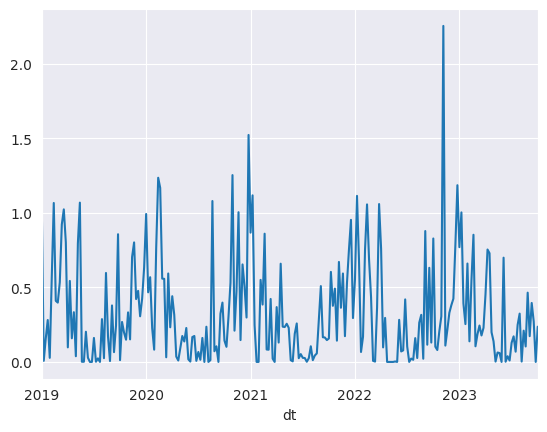

In [37]:
weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

Text(1.0, 0.75, '2021')

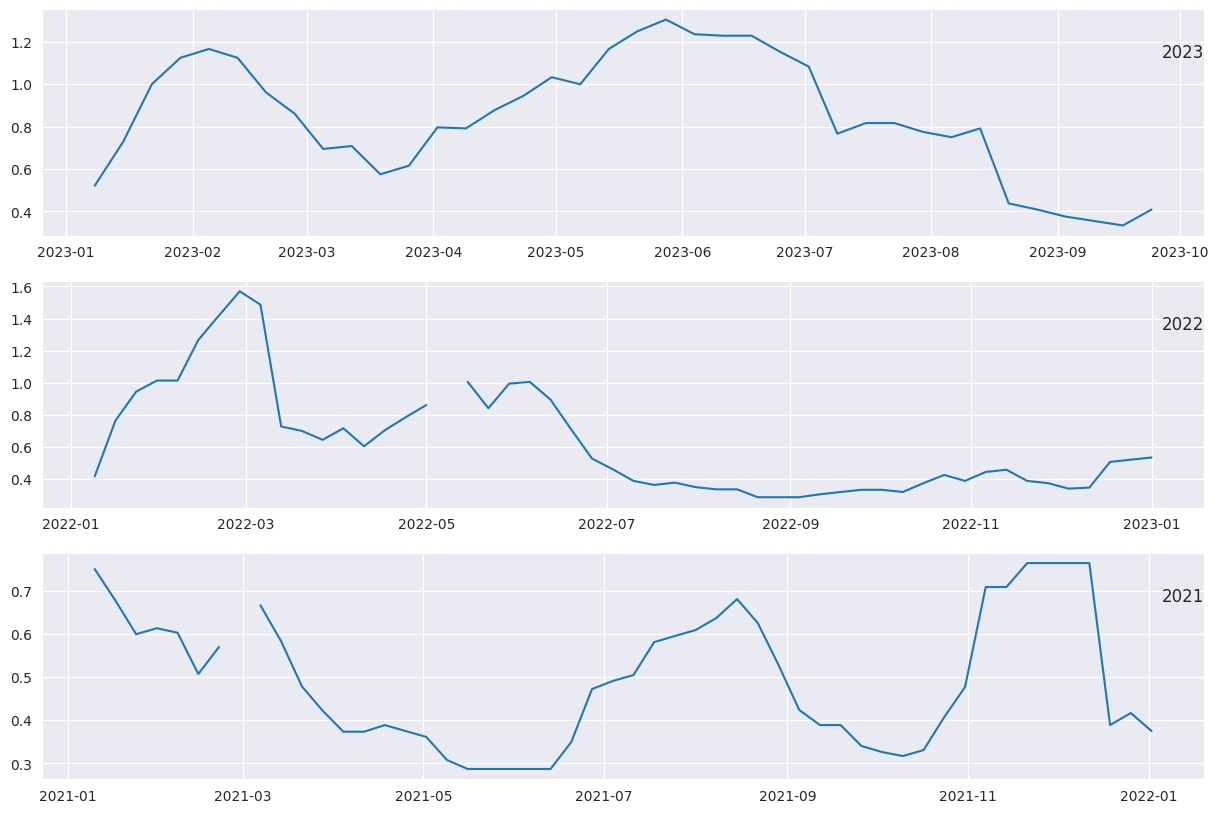

In [32]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]

precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')

In [24]:
precos_2023

,Preco_unitario,week
dt,,
2023-01-06 00:00:00-03:00,0.52083,2023-w01
2023-01-13 00:00:00-03:00,0.72917,2023-w02
2023-01-19 00:00:00-03:00,1.00000,2023-w03
2023-01-27 00:00:00-03:00,1.12500,2023-w04
2023-02-03 00:00:00-03:00,1.16667,2023-w05
2023-02-10 00:00:00-03:00,1.12500,2023-w06
2023-02-16 00:00:00-03:00,0.96125,2023-w07
2023-02-24 00:00:00-03:00,0.86125,2023-w08
2023-03-03 00:00:00-03:00,0.69458,2023-w09


<Axes: xlabel='dt'>

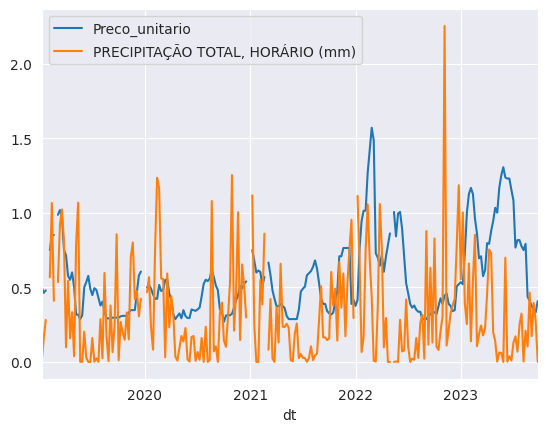

In [55]:
price_precipitation_df = pd.merge(filtered_alface_crespa_roca[filtered_alface_crespa_roca.index >= '2019-01-01'], weather_weekly_df, on='week', how='left')[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]

price_precipitation_df.index = filtered_alface_crespa_roca[filtered_alface_crespa_roca.index >= '2019-01-01'].index
price_precipitation_df.resample('W').mean().plot()